**Fine-tuning an existing BERT model for the emotion classification task**

In [6]:
import pandas as pd
from sklearn import preprocessing


**Data exploration**

In [8]:
df_train = pd.read_csv('./Datasets/data_train.csv')
df_val = pd.read_csv('./Datasets/data_val.csv')
df_test = pd.read_csv('./Datasets/data_test.csv')

le = preprocessing.LabelEncoder()
df_train['Emotion_encoded'] = le.fit_transform(df_train['Emotion'])
df_val['Emotion_encoded'] = le.fit_transform(df_val['Emotion'])
df_test['Emotion_encoded'] = le.fit_transform(df_test['Emotion'])

In [11]:
df_full = pd.concat([df_train, df_val, df_test])

df_full = df_full.drop("Unnamed: 0", axis=1)

df_full.head()

,Text,Emotion,Emotion_encoded
0,i can go from feeling so hopeless to so damned...,sadness,4
1,im grabbing a minute to post i feel greedy wrong,anger,0
2,i am ever feeling nostalgic about the fireplac...,love,3
3,i am feeling grouchy,anger,0
4,ive been feeling a little burdened lately wasn...,sadness,4


In [12]:
#Distribution of the emotions in the dataset

emotion_count = df_full["Emotion"].value_counts()

print(emotion_count)

emotions = emotion_count.index

print(emotions)

joy         6761
sadness     5794
anger       2709
fear        2373
love        1641
surprise     719
Name: Emotion, dtype: int64
Index(['joy', 'sadness', 'anger', 'fear', 'love', 'surprise'], dtype='object')


In [13]:
import matplotlib.pyplot as plt

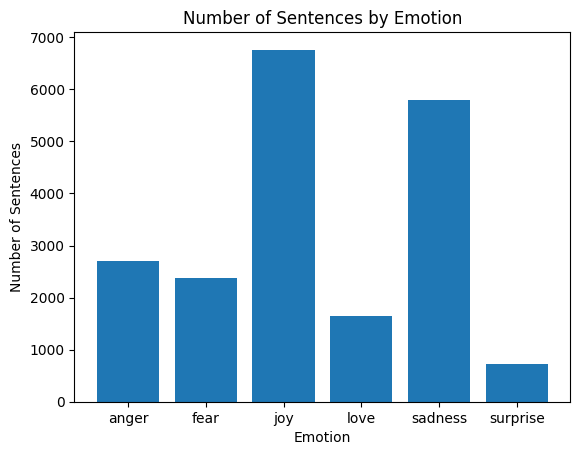

In [15]:
emotion_counts = df_full.groupby('Emotion').count()

plt.bar(emotion_counts.index, emotion_counts['Text'])

#Seting the bar plot title and labels
plt.title('Number of Sentences by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Sentences')

#Displaying the bar plot
plt.show()

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Preprocessing the data**

In [18]:
X_train = list(df_train["Text"])
y_train = list(df_train["Emotion_encoded"])

X_val = list(df_val["Text"])
y_val = list(df_val["Emotion_encoded"])

X_test = list(df_test["Text"])
y_test = list(df_test["Emotion_encoded"])

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


**Creating the Dataset class for representing the data**

In [19]:
#The torch dataset class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [22]:
#Creating instances for the train & validation set

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [30]:
#The evaluation metrics

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}

**Defining & fine-tuning the model**

In [32]:
# Defining the Trainer & its arguments

args = TrainingArguments(
output_dir="output",
num_train_epochs=5,
per_device_train_batch_size=8,
evaluation_strategy='steps',  # evaluate every eval_steps steps
eval_steps=500,  # evaluate every 500 steps
metric_for_best_model='eval_loss'  # use eval_loss for early stopping
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [33]:
#Training the model for 5 epochs

trainer.train()

/Users/patriciagrigor/Desktop/MASTER/second semester/machine learning/emotion_classification/emotion_classification/emotion-venv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(













In [ ]:
#Evaluating the model

trainer.evaluate()

In [ ]:
#Saving the fine-tuned model & tokenizer

trainer.save_model("./EmotionClassificationBERT")

tokenizer.save_pretrained("./EmotionClassificationBERT")

In [ ]:
#Loading the saved model

emotion_classification_model = BertForSequenceClassification.from_pretrained("./EmotionClassificationBERT")

tokenizer = BertTokenizer.from_pretrained("./EmotionClassificationBERT")

In [ ]:
# Evaluating the model with an unseen sentence

text = "I'm happy to see my family during the holidays!"
inputs = tokenizer(text,padding=True, truncation=True, return_tensors='pt')
outputs = emotion_classification_model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()

# Decode the numerical predictions to their corresponding emotions
decoded_predictions = le.inverse_transform(predictions.argmax(axis=1))
print(decoded_predictions)

**Inference using Pytorch**

In [ ]:
#Loading the pre-trained BERT model and the tokenizer
tokenizer = BertTokenizer.from_pretrained("./EmotionClassificationBERT")
model = BertForSequenceClassification.from_pretrained("./EmotionClassificationBERT")

#Loading the test set
test_texts = df_test['Text'].tolist()
test_labels = df_test['Emotion_encoded'].tolist()

#Preprocessing the test set
test_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')
test_labels = torch.tensor(test_labels)

#Performing inferencing
with torch.no_grad()
    outputs = model(**test_inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

#Computing the confusion matrix
cm = confusion_matrix(test_labels, predictions)
print(cm)

#Computing the metrics
report = classification_report(test_labels, predictions)
print(report)